In [1]:
%load_ext autoreload
%autoreload 2


# Cross Strata Detectron2 Fast RCNN

## Experiments Notebook

Authors: Gabrielle Melli, Andrew Foerder

Date: 9/23/2024

# Purpose

The purpose of this notebook is to run training experiements using a Detectron2 COCO detection fast rcnn model to recognize Cross-Strata features in ariel images of Earth and Mars.

# Methods

## User Settings

Andrew steps:
1. Change settings in cell below
2. Runtime > Run all
3. Wait 2 minutes to see if login is prompted
4. Go enjoy a cup of tea for 20 minutes
5. Come back look at results - decide what to change for next experiment round
6. You can play around with threshold and image outputs until you like what you wanna screenshot - then screenshot and label screenshot with experiment number
7. Repeat!



In [2]:
# These following lines are the experiment settings to overwrite the config file.
# Whichever lines are uncommented will overwrite the settings loaded from the
# config.yaml file in working_directory. Anything setting still commented will
# not update and instead defer to the settings in the config.yaml file.

# ANDREW: I stg you better change this number
experiment_number = 20

dataloader__num_workers = 2 # default 2

# ANDREW: Only change one of the below settings per experiment
# model_zoo_cfg = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
solver__ims_per_batch = 4 # default 2 (went up to 8)
solver__base_learning_rate = 0.00099 #***** default 0.00025 (pretty low) test 3 values within range of that paper (went up to 0.1)
solver__max_iter = 8000 # default 600 #***** keep iterating if you see loss going down (went up to 12,000)
solver__steps = [] # default []
model__roi_heads__batch_size_per_image = 128 # default 128
# model__roi_heads__score_threshold_test = 0.5 # default 0.5 idk if this actually changes the results


In [3]:
# Nothing here needs to change

# slice_images and grayscale are assumed to be true for now - don't change
##### as of right now this will overwrite our other saved slices - let gabby know if we want to try slicing a different size and she can make changes
# slice_size = [500,500]

# Change the following filepath for most updated White Sands satellite labeled images
# Format is 'MM_DD_YY.json'
label_date_recent = '09_26_24.json' # TODO automate this


In [4]:
# Connect to GDrive to access image files and labels
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Change working directory to drive so that everything saves to drive
%cd '/content/gdrive/MyDrive/__Shared/Andrew/working_directory'
%pwd

/content/gdrive/.shortcut-targets-by-id/1Bhg_-iEsxa3Aq4v-SLxPVOpKrY5TpKaq/Andrew/working_directory


'/content/gdrive/.shortcut-targets-by-id/1Bhg_-iEsxa3Aq4v-SLxPVOpKrY5TpKaq/Andrew/working_directory'

In [6]:
import pprint
from config_utils import Config

In [7]:
c = Config()

# c.cfg['train_datasets'] = ['white_sands_sat']
# c.cfg['val_datasets'] = ['white_sands_sat', 'mars_hirise']
# c.cfg['test_datasets'] = ['white_sands_sat', 'mars_hirise']

if 'experiment_number' in locals():
  c.cfg['experiment_number'] = locals()['experiment_number']


for setting in c.cfg['preprocess_settings'].keys():
  if setting in locals():
    c.cfg['preprocess_settings'][setting] = locals()[setting]


model_settings = ['model_zoo_cfg',
                 'dataloader__num_workers',
                 'solver__ims_per_batch',
                 'solver__base_learning_rate',
                 'solver__max_iter',
                 'solver__steps',
                 'model__roi_heads__batch_size_per_image',
                 'model__roi_heads__num_classes',
                 'model__roi_heads__score_threshold_test']

for setting in model_settings:
  if setting in locals():
    c.cfg['model_settings'][setting] = locals()[setting]


In [8]:
# Check this output to make sure your settings have changed

pprint.pp(c.cfg)

{'experiment_number': 20,
 'preprocess_steps': ['slice_images', 'grayscale'],
 'preprocess_settings': {'slice_size': [500, 500]},
 'train_datasets': ['white_sands_sat'],
 'val_datasets': ['white_sands_sat', 'mars_hirise'],
 'test_datasets': ['white_sands_sat', 'mars_hirise'],
 'model_settings': {'model_zoo_cfg': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml',
                    'dataloader__num_workers': 2,
                    'solver__ims_per_batch': 4,
                    'solver__base_learning_rate': 0.00099,
                    'solver__max_iter': 8000,
                    'solver__steps': [],
                    'model__roi_heads__batch_size_per_image': 128,
                    'model__roi_heads__num_classes': 1,
                    'model__roi_heads__score_threshold_test': 0.7},
 'datasets': ['white_sands_sat', 'mars_hirise'],
 'classes': ['xstrata'],
 'env_paths': {'google_colab': {'working_dir': '/content/gdrive/MyDrive/__Shared/Andrew/working_directory',
             

In [9]:
# Doing the path calculations; uncomment print statements if you need a reference (ANDREW: you probably won't need this)

c.get_paths()
# pprint.pp(c.raw_paths)
# pprint.pp(c.preproc_paths)
# pprint.pp(c.split_paths)

## Setup

In [10]:
%%capture
# GAB TODO figure out if some of this can be removed
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

!python -m pip install split-folders
!pip install pycocotools
!pip install ujson

In [11]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [12]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import libraries that allow for dataset generation
import splitfolders
import ujson as json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, DatasetEvaluators

# import functions written for this project
from data_processing.data_load import get_anno_path, split_json_train_test_val
from data_processing.data_preprocess import slice_batch, grayscale_image, is_anno_out_of_bounds

## Dataset Processing - moved to new notebook


In [13]:
# gs = True # if we need to drop into the grayscale preprocessing


### Dataset Registering


In [14]:
# # check if all datasets exist

for dataset in c.cfg['datasets']:
  assert os.path.exists(c.split_paths[dataset]['train_images_dir'])
  assert os.path.exists(c.split_paths[dataset]['val_images_dir'])
  assert os.path.exists(c.split_paths[dataset]['test_images_dir'])

In [15]:
# get the original labels, split them, and register datasets
tr = []
v = []
ts = []

#for dataset in c.cfg['datasets']:
  # if resplit_json:
  #   if len(c.cfg['preprocess_steps']) > 0:
  #     anno_path = c.preproc_paths[dataset]['labels']
  #   else:
  #     anno_path = get_anno_path(c.raw_paths[dataset]['labels_dir'], label_date_recent)

  #   split_json_train_test_val(json_filepath = anno_path,
  #                             image_dirs = [c.split_paths[dataset]['train_images_dir'],
  #                                           c.split_paths[dataset]['val_images_dir'],
  #                                           c.split_paths[dataset]['test_images_dir']],
  #                             anno_dirs = [c.split_paths[dataset]['train_labels'],
  #                                          c.split_paths[dataset]['val_labels'],
  #                                          c.split_paths[dataset]['test_labels']])

for dataset in c.cfg['train_datasets']:
  train_dataset = dataset + '_train'
  tr.append(dataset + '_train')
  register_coco_instances(train_dataset, {}, c.split_paths[dataset]['train_labels'], c.split_paths[dataset]['train_images_dir'])

for dataset in c.cfg['val_datasets']:
  val_dataset = dataset + '_val'
  v.append(dataset + '_val')
  register_coco_instances(val_dataset, {}, c.split_paths[dataset]['val_labels'], c.split_paths[dataset]['val_images_dir'])

for dataset in c.cfg['test_datasets']:
  test_dataset = dataset + '_test'
  ts.append(dataset + '_test')
  register_coco_instances(test_dataset, {}, c.split_paths[dataset]['test_labels'], c.split_paths[dataset]['test_images_dir'])

train_datasets = tuple(tr)
val_datasets = tuple(v)
test_datasets = tuple(ts)

print(train_datasets)
print(val_datasets)
print(test_datasets)

('white_sands_sat_train',)
('white_sands_sat_val', 'mars_hirise_val')
('white_sands_sat_test', 'mars_hirise_test')


In [16]:
# This cell and the one below to test splitting outputs - ignore for now


# import random
# import cv2
# from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow


# train_dataset_dicts = DatasetCatalog.get(train_datasets[2])
train_metadata = MetadataCatalog.get(train_datasets[0])

In [17]:
# TESTING FOR DATASET SPLITTING - ignore for now

# for d in random.sample(train_dataset_dicts, 10):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

## Model Training

In [18]:
# initiate a detectron2 config object
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(c.cfg['model_settings']['model_zoo_cfg']))
cfg.DATASETS.TRAIN = train_datasets
cfg.DATASETS.TEST = ()

# load settings from config
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(c.cfg['model_settings']['model_zoo_cfg'])

cfg.DATALOADER.NUM_WORKERS = c.cfg['model_settings']['dataloader__num_workers']

cfg.INPUT.MIN_SIZE_TRAIN = (500,)
cfg.INPUT.MIN_SIZE_TEST = 500

cfg.SOLVER.IMS_PER_BATCH = c.cfg['model_settings']['solver__ims_per_batch']
cfg.SOLVER.BASE_LR = c.cfg['model_settings']['solver__base_learning_rate']
cfg.SOLVER.MAX_ITER = c.cfg['model_settings']['solver__max_iter']                                               # comment from detectron2 tutorial: 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = c.cfg['model_settings']['solver__steps']                                                     # comment from detectron2 tutorial: do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = c.cfg['model_settings']['model__roi_heads__batch_size_per_image']    # comment from detectron2 tutorial: The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = c.cfg['model_settings']['model__roi_heads__num_classes']
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = c.cfg['model_settings']['model__roi_heads__score_threshold_test']

# creates directories to output results
cfg.OUTPUT_DIR = os.path.join(c.cfg['env_paths']['google_colab']['output_path'],
                              f'experiment_{c.cfg["experiment_number"]}')
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [19]:
import yaml

cfg_yaml_path = os.path.join(cfg.OUTPUT_DIR, 'config.yaml')
with open(cfg_yaml_path, 'w') as path:
  yaml.dump(cfg, path)

print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('white_sands_sat_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 500
  MIN_SIZE_TRAIN: (500,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['r

In [20]:
# define detectron2 trainer object using the cfg object we defined above
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/06 21:56:33 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 216MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[11/06 21:58:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/06 21:58:59 d2.utils.events]:  eta: 1:31:47  iter: 19  total_loss: 2.186  loss_cls: 0.7142  loss_box_reg: 0.1652  loss_mask: 0.6929  loss_rpn_cls: 0.4954  loss_rpn_loc: 0.04398    time: 0.7213  last_time: 0.8827  data_time: 0.4983  last_data_time: 0.5864   lr: 1.9781e-05  max_mem: 1551M
[11/06 21:59:15 d2.utils.events]:  eta: 1:31:25  iter: 39  total_loss: 1.921  loss_cls: 0.4085  loss_box_reg: 0.1844  loss_mask: 0.6911  loss_rpn_cls: 0.5055  loss_rpn_loc: 0.06412    time: 0.6900  last_time: 0.6904  data_time: 0.3668  last_data_time: 0.3849   lr: 3.9561e-05  max_mem: 1551M
[11/06 21:59:29 d2.utils.events]:  eta: 1:30:31  iter: 59  total_loss: 1.583  loss_cls: 0.268  loss_box_reg: 0.1015  loss_mask: 0.6866  loss_rpn_cls: 0.2965  loss_rpn_loc: 0.04355    time: 0.6907  last_time: 0.7157  data_time: 0.4024  last_data_time: 0.4049   lr: 5.9342e-05  max_mem: 1551M
[11/06 21:59:42 d2.utils.events]:  eta: 1:27:50  iter: 79  total_loss: 1.377  loss_cls: 0.198  loss_box_reg: 0.1633  loss_mas

In [21]:
from detectron2.utils.visualizer import ColorMode

val_metadata = MetadataCatalog.get(val_datasets[0]) # more white sands
val_dataset_dicts = DatasetCatalog.get(val_datasets[0])

test_metadata = MetadataCatalog.get(test_datasets[1]) # mars!
test_dataset_dicts = DatasetCatalog.get(test_datasets[1])

[11/06 22:59:09 d2.data.datasets.coco]: Loading output/data/white_sands_sat/val/labels.json takes 27.78 seconds.
WARNING [11/06 22:59:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/06 22:59:10 d2.data.datasets.coco]: Loaded 1027 images in COCO format from output/data/white_sands_sat/val/labels.json
[11/06 22:59:13 d2.data.datasets.coco]: Loaded 71 images in COCO format from output/data/mars_hirise/test/labels.json


In [22]:
# Once the model has trained, go ahead and mess with the score threshold again until you like the output of the cell below

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # this you can change! rerun this cell only and the one below
predictor = DefaultPredictor(cfg)

[11/06 23:12:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/experiment_20/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

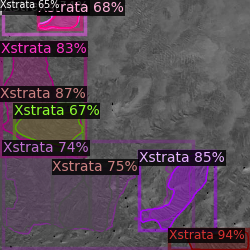

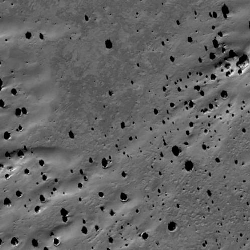

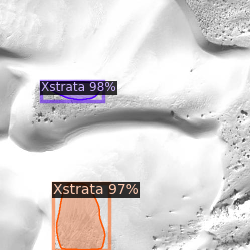

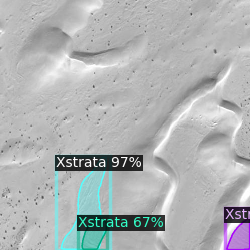

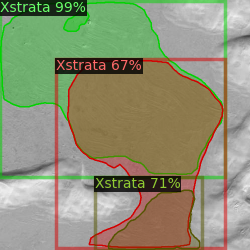

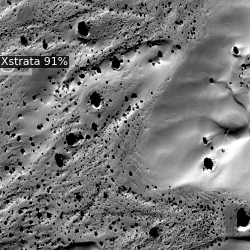

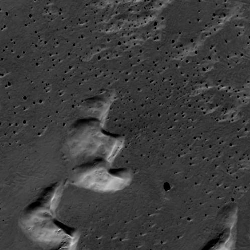

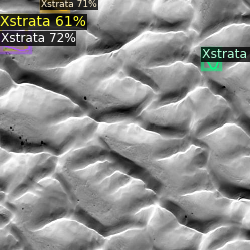

In [23]:
import random
import cv2
from google.colab.patches import cv2_imshow

# WHITE SANDS SAT

#random.seed(320) #ANDREW: you can change this number until you like the images that pop out of the 'random selection'
random.seed(100)
for d in random.sample(val_dataset_dicts, 8):
  im = cv2.imread(d['file_name'])
  outputs = predictor(im)
  v = Visualizer(im[:,:, ::-1],
                 metadata = val_metadata,
                 scale = 0.5,
                 instance_mode = ColorMode.IMAGE_BW)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:,:, ::-1])

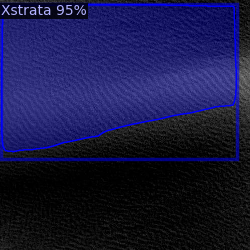

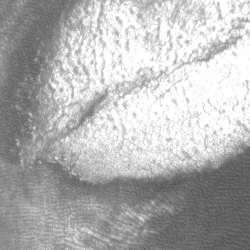

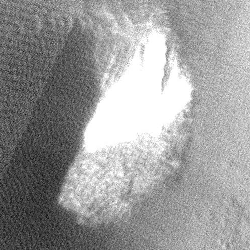

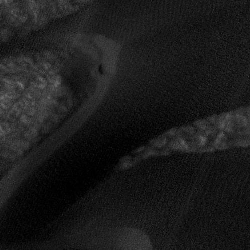

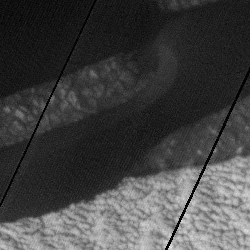

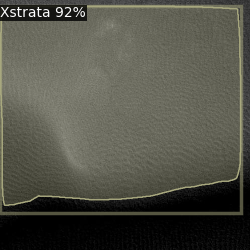

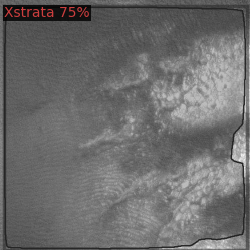

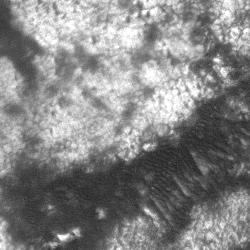

In [24]:
#random.seed(320) #ANDREW: you can change this number until you like the images that pop out of the 'random selection'
random.seed(100)

# MARS

for d in random.sample(test_dataset_dicts, 8):
  im = cv2.imread(d['file_name'])
  outputs = predictor(im)
  v = Visualizer(im[:,:, ::-1],
                 metadata = val_metadata,
                 scale = 0.5,
                 instance_mode = ColorMode.IMAGE_BW)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:,:, ::-1])

In [27]:
# Evaluation on white sands sat

evaluator_ws = COCOEvaluator(dataset_name = val_datasets[0],
                          tasks = ('bbox', 'segm'),
                          distributed = False,
                          output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, val_datasets[0])
inference_on_dataset(trainer.model, val_loader, evaluator_ws)

[11/06 23:20:52 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/06 23:21:47 d2.data.datasets.coco]: Loading output/data/white_sands_sat/val/labels.json takes 27.29 seconds.
WARNING [11/06 23:21:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/06 23:21:47 d2.data.datasets.coco]: Loaded 1027 images in COCO format from output/data/white_sands_sat/val/labels.json
[11/06 23:21:49 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  Xstrata   | 410297       |
|            |              |
[11/06 23:21:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(500, 500), max_size=1333, sample_style='choice')]
[11/06 23:21:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/06 23:21:4

OrderedDict([('bbox',
              {'AP': 0.5084920772779031,
               'AP50': 0.99009900990099,
               'AP75': 0.49504950495049505,
               'APs': 0.6594766619519095,
               'APm': 0.5860831373378318,
               'APl': 0.4851485148514851}),
             ('segm',
              {'AP': 0.6326682890116873,
               'AP50': 0.99009900990099,
               'AP75': 0.7128712871287128,
               'APs': 0.612084285351612,
               'APm': 0.6216884557165954,
               'APl': 0.6720937916576467})])

In [28]:
# Evaluation on mars

evaluator_mars = COCOEvaluator(dataset_name = test_datasets[0],
                          tasks = ('bbox', 'segm'),
                          distributed = False,
                          output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, test_datasets[0])
inference_on_dataset(trainer.model, val_loader, evaluator_mars)

[11/06 23:26:06 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/06 23:26:28 d2.data.datasets.coco]: Loading output/data/white_sands_sat/test/labels.json takes 12.17 seconds.
WARNING [11/06 23:26:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/06 23:26:28 d2.data.datasets.coco]: Loaded 514 images in COCO format from output/data/white_sands_sat/test/labels.json
[11/06 23:26:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(500, 500), max_size=1333, sample_style='choice')]
[11/06 23:26:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/06 23:26:28 d2.data.common]: Serializing 514 elements to byte tensors and concatenating them all ...
[11/06 23:26:30 d2.data.common]: Serialized dataset takes 269.00 MiB
[11/06 23:26:30 d2.evaluation.evaluator]:

OrderedDict([('bbox',
              {'AP': 0.7488034291764487,
               'AP50': 0.9900990099009901,
               'AP75': 0.9900990099009901,
               'APs': 0.7920792079207921,
               'APm': 0.7381521223626231,
               'APl': 0.798267326732673}),
             ('segm',
              {'AP': 0.7226162247469791,
               'AP50': 0.9900990099009901,
               'AP75': 0.9900990099009901,
               'APs': 0.6064356435643563,
               'APm': 0.7195288494366678,
               'APl': 0.7433531129004242})])

## Inference on Hold Out Mars Images

In [29]:
input_images_directory = '/content/gdrive/MyDrive/__Shared/Andrew/working_directory/data_sources/mars_hirise/not_annotated/grayscale'
output_directory = os.path.join(cfg.OUTPUT_DIR, 'inference')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

In [30]:
import csv
from skimage.measure import regionprops, label

# Output directory where the CSV file will be saved
output_csv_path = output_directory = os.path.join(cfg.OUTPUT_DIR, 'inference.csv')  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Check if the mask is empty
        if mask.size == 0:
            print(f"Skipping image {image_filename} due to empty mask.")
            continue  # Skip to the next image

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")

Skipping image ESP_036099_2615_RED_1 (1).jpg due to empty mask.
Skipping image ESP_036099_2615_RED_1.jpg due to empty mask.
Object-level information saved to CSV file.
